In [5]:
import numpy as np
import pandas as pd
from scipy import stats
path_to_file= r"vietnam_housing_dataset.csv"
vietnam_housing = pd.read_csv(r"vietnam_housing_dataset.csv")
vietnam_housing = vietnam_housing[['Address',	'Area',	'Frontage',	'Access Road',  'House direction',	'Balcony direction', 	'Floors',	'Bedrooms',	'Bathrooms',	'Legal status',	'Furniture state',	'Price']]

# TIỀN XỬ LÝ DỮ LIỆU

In [6]:
vietnam_housing.isna().any()

Address              False
Area                 False
Frontage              True
Access Road           True
House direction       True
Balcony direction     True
Floors                True
Bedrooms              True
Bathrooms             True
Legal status          True
Furniture state       True
Price                False
dtype: bool

In [7]:
vietnam_housing.dropna(inplace=True)

In [8]:
vietnam_housing.duplicated().any()

np.False_

In [9]:
vietnam_housing.drop_duplicates(inplace=True)

In [10]:
# Xử lí giá missing values
vietnam_housing['Frontage']  = vietnam_housing['Frontage'].fillna(vietnam_housing['Frontage'].median())
vietnam_housing['Access Road'] = vietnam_housing['Access Road'].fillna(vietnam_housing['Access Road'].median())
vietnam_housing['Floors']    = vietnam_housing['Floors'].fillna(vietnam_housing['Floors'].median())
vietnam_housing['Bedrooms']  = vietnam_housing['Bedrooms'].fillna(vietnam_housing['Bedrooms'].median())
vietnam_housing['Bathrooms'] = vietnam_housing['Bathrooms'].fillna(vietnam_housing['Bathrooms'].median())

for col in ['House direction', 'Balcony direction', 'Legal status', 'Furniture state']:
    vietnam_housing[col] = vietnam_housing[col].fillna('Unknown')


In [11]:
# Kiểm tra trùng lặp lần nữa
vietnam_housing.drop_duplicates(inplace=True)
vietnam_housing.describe()


,Area,Frontage,Access Road,Floors,Bedrooms,Bathrooms,Price
count,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000,2645.000000
mean,70.722979,5.480749,7.605142,3.209452,3.473346,3.355009,5.444760
std,50.359338,4.917664,7.571208,1.277935,1.182540,1.341140,2.240992
min,3.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,40.000000,4.000000,3.000000,2.000000,3.000000,2.000000,3.680000
50%,60.000000,4.500000,5.000000,3.000000,3.000000,3.000000,5.250000
75%,83.000000,5.000000,8.000000,4.000000,4.000000,4.000000,7.190000
max,501.000000,73.000000,85.000000,7.000000,9.000000,9.000000,10.900000


### Xử lí outliners

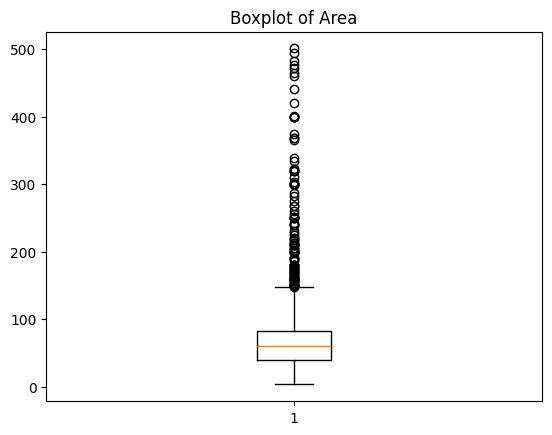

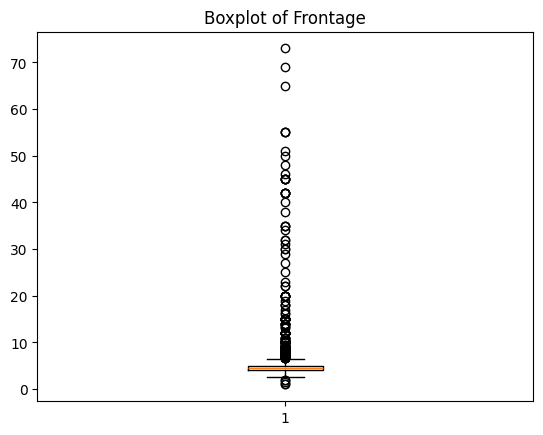

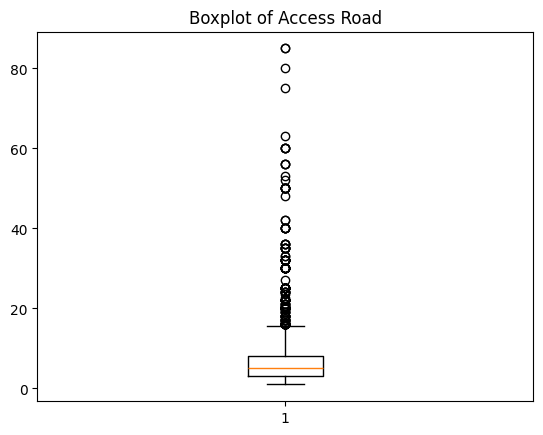

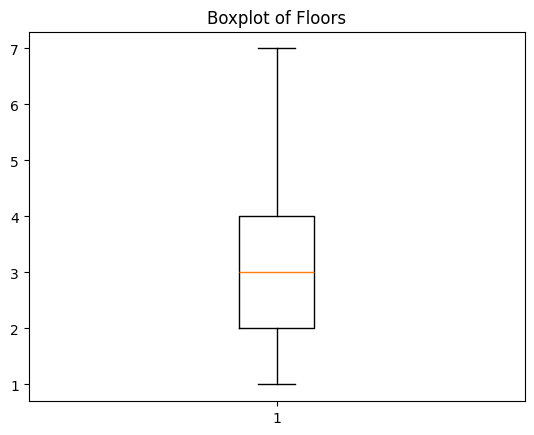

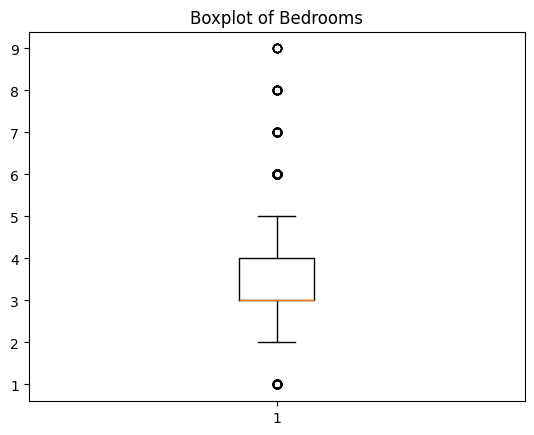

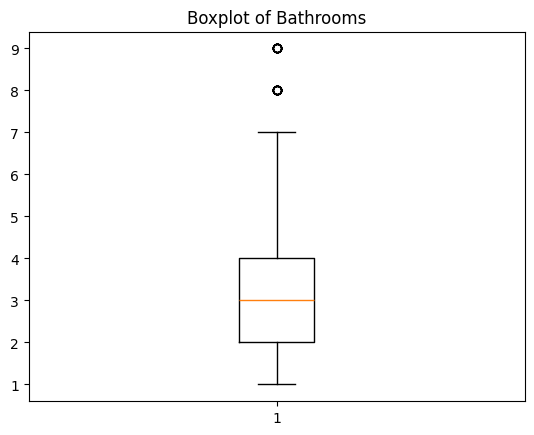

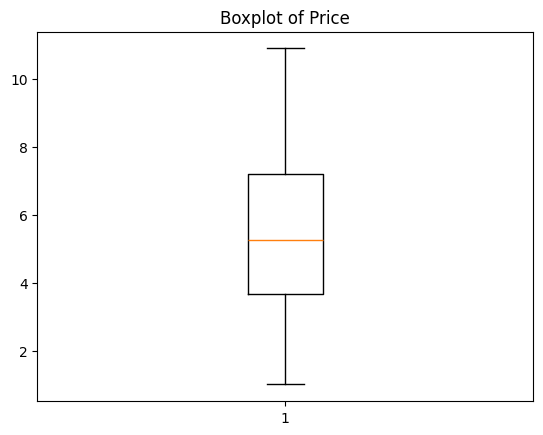

In [12]:
import matplotlib.pyplot as plt

cols = ['Area', 'Frontage', 'Access Road', 'Floors',	'Bedrooms',	'Bathrooms',	'Price']
for col in cols:
    plt.figure()
    plt.boxplot(vietnam_housing[col])
    plt.title(f'Boxplot of {col}')
    plt.show()
vietnam_housing = vietnam_housing[(np.abs(stats.zscore(vietnam_housing[cols])) < 3).all(axis=1)]

In [13]:
import sklearn
from sklearn.datasets import load_diabetes
import pandas as pd
print("Old Shape: ", vietnam_housing.shape)
cols = ['Area', 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms']
for col in cols:
    # Tính các giá trị phân vị
    Q1 = vietnam_housing[col].quantile(0.25)
    Q3 = vietnam_housing[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Tìm chỉ số các giá trị nằm ngoài giới hạn
    upper_array = np.where(vietnam_housing[col] > upper)[0]
    lower_array = np.where(vietnam_housing[col] < lower)[0]
 # Tạo mask xác định outliers
    mask = (vietnam_housing[col] < lower) | (vietnam_housing[col] > upper)
    n_outliers = mask.sum()
    # Giữ lại những dòng hợp lệ
    vietnam_housing = vietnam_housing.loc[~mask]
print("New Shape:", vietnam_housing.shape)

Old Shape:  (2499, 12)
New Shape: (1981, 12)


In [14]:
for col in ['Area', 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms']:
    Q1 = vietnam_housing[col].quantile(0.25)
    Q3 = vietnam_housing[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    mask = (vietnam_housing[col] < lower) | (vietnam_housing[col] > upper)
    print(f"{col}: {mask.sum()} outliers")


Area: 13 outliers
Frontage: 0 outliers
Access Road: 31 outliers
Bedrooms: 0 outliers
Bathrooms: 0 outliers


### Chuẩn hóa dữ liệu

In [15]:
# chuẩn hóa dữ liệu
from sklearn.preprocessing import StandardScaler
cols_to_scale = ['Area', 'Frontage', 'Access Road', 'Bedrooms', 'Bathrooms', 'Price']
vietnam_housing= pd.DataFrame(vietnam_housing)
scaler = StandardScaler()
# Áp dụng chuẩn hóa
vietnam_housing_scaled = vietnam_housing.copy()  # Tạo bản sao để giữ dữ liệu gốc
vietnam_housing_scaled[cols_to_scale] = scaler.fit_transform(vietnam_housing[cols_to_scale])
res = pd.DataFrame(vietnam_housing_scaled, columns=vietnam_housing.columns)
print(res)

                                                 Address      Area  Frontage  \
19     Đường Quang Trung, Phường 12, Gò Vấp, Hồ Chí Minh -0.521553  0.281668   
61     Đường Nguyễn Trung Trực, Phường 5, Bình Thạnh,...  0.426969 -0.511298   
111      Phố Yên Duyên, Phường Yên Sở, Hoàng Mai, Hà Nội -1.055353 -1.832909   
112    Đường Nguyễn Đình Chính, Phường 11, Phú Nhuận,... -0.850045 -0.246976   
142                  Phường Thạch Bàn, Long Biên, Hà Nội -1.055353  0.149507   
...                                                  ...       ...       ...   
30122  Phố Nguyễn Huy Tự, Phường Hòa Minh,Quận Liên C...  0.463924  0.149507   
30126  Đường Lê Công Thanh, Phường Trần Hưng Đạo, Phủ...  0.188812  0.281668   
30186  Hẻm 160/, Đường Nguyễn Chí Thanh, Phường 3, Qu... -1.556304 -2.361553   
30204  Đường Hòa Bình, Phường Yên Nghĩa, Hà Đông, Hà Nội -1.096415 -1.304265   
30218  Đường Nguyễn Thị Thập, Phường Bình Thuận, Quận... -0.291608 -0.511298   

       Access Road House direction Balc

In [16]:
# Kiểm tra mean và std sau chuẩn hóa
print("\nMean sau chuẩn hóa:\n", vietnam_housing_scaled[cols_to_scale].mean())
print("\nStd sau chuẩn hóa:\n", vietnam_housing_scaled[cols_to_scale].std())


Mean sau chuẩn hóa:
 Area           6.456219e-17
Frontage      -1.375533e-15
Access Road   -3.586788e-18
Bedrooms       2.941166e-16
Bathrooms     -2.331412e-17
Price          1.972733e-16
dtype: float64

Std sau chuẩn hóa:
 Area           1.000252
Frontage       1.000252
Access Road    1.000252
Bedrooms       1.000252
Bathrooms      1.000252
Price          1.000252
dtype: float64


In [17]:
# xóa các khoảng trắng thay đinh do bằng gạch dưới
vietnam_housing.columns = vietnam_housing.columns.str.replace(' ', '_')

In [18]:
# Mã hóa bằng label encoding
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
vietnam_housing['House_direction'] = encoder.fit_transform(vietnam_housing['House_direction'])
vietnam_housing['Balcony_direction'] = encoder.fit_transform(vietnam_housing['Balcony_direction'])
vietnam_housing['Legal_status'] = encoder.fit_transform(vietnam_housing['Legal_status'])
vietnam_housing['Furniture_state'] = encoder.fit_transform(vietnam_housing['Furniture_state'])


### PHÂN CỤM DỮ LIỆU

In [19]:
vietnam_housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1981 entries, 19 to 30218
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Address            1981 non-null   object 
 1   Area               1981 non-null   float64
 2   Frontage           1981 non-null   float64
 3   Access_Road        1981 non-null   float64
 4   House_direction    1981 non-null   int64  
 5   Balcony_direction  1981 non-null   int64  
 6   Floors             1981 non-null   float64
 7   Bedrooms           1981 non-null   float64
 8   Bathrooms          1981 non-null   float64
 9   Legal_status       1981 non-null   int64  
 10  Furniture_state    1981 non-null   int64  
 11  Price              1981 non-null   float64
dtypes: float64(7), int64(4), object(1)
memory usage: 201.2+ KB


In [20]:
# Xây dựng mô hình K-Means
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
X = vietnam_housing[['Area', 'Frontage', 'Bedrooms','Bathrooms','Furniture_state', 'Price']]
km_inertias, km_scores = [], []
for k in range(3, 10):
 km = KMeans(n_clusters=k).fit(X)
 km_inertias.append(km.inertia_)
 km_scores.append(silhouette_score(X, km.labels_))
 print(f"Processing K-Means with k = {k}, Intertia = {km.inertia_},Silhoutte Score = {silhouette_score(X, km.labels_)}")
km_inertias

Processing K-Means with k = 3, Intertia = 174115.7514455097,Silhoutte Score = 0.5704062114481996


Processing K-Means with k = 4, Intertia = 110207.41956832507,Silhoutte Score = 0.5338833051948625
Processing K-Means with k = 5, Intertia = 89880.8738333774,Silhoutte Score = 0.4616705474468405
Processing K-Means with k = 6, Intertia = 61682.26718868695,Silhoutte Score = 0.49111479364383087
Processing K-Means with k = 7, Intertia = 47387.76768019452,Silhoutte Score = 0.4738687003502391
Processing K-Means with k = 8, Intertia = 38395.700035277194,Silhoutte Score = 0.4384569819554195
Processing K-Means with k = 9, Intertia = 34425.58742856058,Silhoutte Score = 0.41298246775036745


[174115.7514455097,
 110207.41956832507,
 89880.8738333774,
 61682.26718868695,
 47387.76768019452,
 38395.700035277194,
 34425.58742856058]

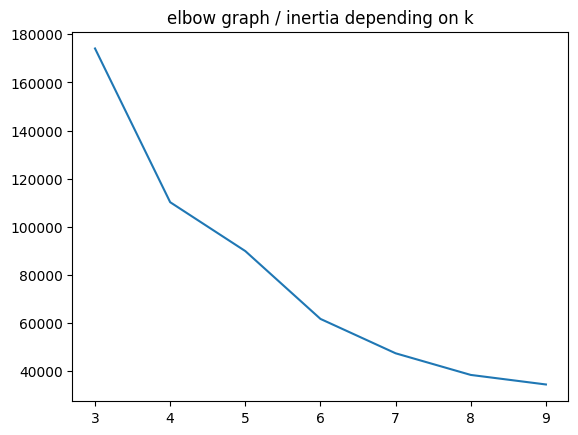

k = 3, Silhouette Score = 0.557
k = 4, Silhouette Score = 0.527
k = 5, Silhouette Score = 0.527
k = 6, Silhouette Score = 0.487
k = 7, Silhouette Score = 0.456
k = 8, Silhouette Score = 0.429
k = 9, Silhouette Score = 0.419


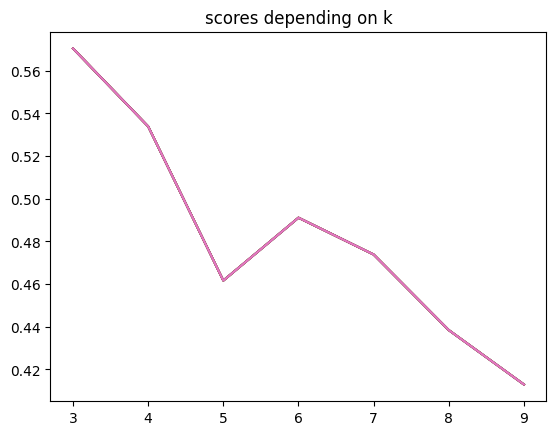

In [21]:
# sns.lineplot(range(3, 10), km_inertias) PHUOCNT
sns.lineplot(x=range(3, 10), y=km_inertias)
plt.title('elbow graph / inertia depending on k')
plt.show()
# Bổ sung kiểm tra bằng Silhouette Score
from sklearn.metrics import silhouette_score
for k in range(3, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    score = silhouette_score(X, km.labels_)
    print(f"k = {k}, Silhouette Score = {score:.3f}")
    sns.lineplot(x=range(3, 10), y=km_scores)
plt.title('scores depending on k')
plt.show()


In [22]:
# Gán nhãn cho các mẫu dữ liệu dựa vào mô hình K-Means với số cụm là 5 và 6
km = KMeans(n_clusters=5).fit(X)
#Assign the Cluster Labels to the Data
X['Label'] = km.labels_
#Info for each cluster
for k in range(5):
 print(f'Cluster nb : {k}')
 print(X[X.Label == k].describe().iloc[:, 1:-1])
 print('\n\n')
 

Cluster nb : 0
         Frontage    Bedrooms   Bathrooms  Furniture_state       Price
count  637.000000  637.000000  637.000000       637.000000  637.000000
mean     3.977488    3.158556    3.260597         0.563579    4.532245
std      0.745313    0.778026    0.913509         0.496331    1.837981
min      2.500000    2.000000    1.000000         0.000000    1.000000
25%      3.500000    3.000000    3.000000         0.000000    3.200000
50%      4.000000    3.000000    3.000000         1.000000    4.350000
75%      4.200000    4.000000    4.000000         1.000000    5.600000
max      6.500000    5.000000    6.000000         1.000000   10.000000



Cluster nb : 1
         Frontage    Bedrooms   Bathrooms  Furniture_state       Price
count  419.000000  419.000000  419.000000       419.000000  419.000000
mean     4.486539    3.410501    3.322196         0.615752    5.537041
std      0.627852    0.857550    1.246530         0.486999    2.197082
min      3.000000    2.000000    1.000000   

In [23]:
# Gán nhãn cho các mẫu dữ liệu dựa vào mô hình K-Means với số cụm là 5 và 6
km = KMeans(n_clusters=6).fit(X)
#Assign the Cluster Labels to the Data
X['Label'] = km.labels_
#Info for each cluster
for k in range(6):
 print(f'Cluster nb : {k}')
 print(X[X.Label == k].describe().iloc[:, 1:-1])
 print('\n\n')

Cluster nb : 0
         Frontage    Bedrooms   Bathrooms  Furniture_state       Price
count  459.000000  459.000000  459.000000       459.000000  459.000000
mean     3.921808    3.054466    3.278867         0.544662    4.273224
std      0.754390    0.726357    0.886957         0.498545    1.690003
min      2.500000    2.000000    1.000000         0.000000    1.000000
25%      3.410000    3.000000    3.000000         0.000000    2.980000
50%      3.900000    3.000000    3.000000         1.000000    4.150000
75%      4.150000    3.000000    4.000000         1.000000    5.250000
max      6.500000    5.000000    6.000000         1.000000   10.000000



Cluster nb : 1
         Frontage    Bedrooms   Bathrooms  Furniture_state       Price
count  238.000000  238.000000  238.000000       238.000000  238.000000
mean     4.808739    3.306723    3.142857         0.588235    5.868950
std      0.694046    0.807688    1.234427         0.493190    2.210219
min      3.480000    2.000000    1.000000   

In [27]:
print("KMeans n_clusters:", km.n_clusters)
print("Shape of X_scaled:", X.shape)
print("Unique cluster labels:", np.unique(X['Label']))
print("Number of duplicates:", vietnam_housing.duplicated().sum())


KMeans n_clusters: 6
Shape of X_scaled: (1981, 7)
Unique cluster labels: [0 1 2 3 4 5]
Number of duplicates: 0
